In [1]:
from tkinter.filedialog import askopenfilename                    # to prompt a file directory selection box
import trimesh                                                    # useful functions to manipulate triangular meshes
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.api as sm

In [2]:
#Removes the outlier vertices from the slice
def filter_slice(vertices):
    filtered_slice = []
    for vertex in vertices:
        if (vertex[0] >= -100 and vertex[0] <= 100 and vertex[1] < 50):   # Only retains vertices that are within X = -100mm to 100mm and within Y < 50mm
            filtered_slice.append(vertex)
    
    return filtered_slice

In [3]:
# Returns the numerical 1st derivative of the provided slice
def differentiate_slice(vertices):
    differentiated_slice = []
    for vertex in vertices:
        if (vertex[0] == vertices[0,0]):
            prev_vertex = vertex
            continue
        else: 
            derivative = (vertex[1] - prev_vertex[1]) / (vertex[0] - prev_vertex[0])     # forward derivative
            differentiated_slice.append([vertex[0], derivative])
            prev_vertex = vertex
            
    return differentiated_slice

In [4]:
# Calculates the tread depths given an array of vertices (a slice)
def calculate_tread_depth(vertices):
    diff_vertices = differentiate_slice(vertices)               # Differentiate the slice
    diff_vertices = np.asarray(diff_vertices)                   # Convert to numpy array
    np.set_printoptions(suppress=True)                          # Removes scientific notation (otherwise scientific notation by default)
    second_diff_vertices = differentiate_slice(diff_vertices)   # Get the second derivative of the slice
    second_diff_vertices = np.asarray(second_diff_vertices)     # Convert to numpy array
    
    # Initialize the three important tread locations
    upper_tread_left = []      
    upper_tread_right = []
    lower_tread = []
    
    # Locates the upper_tread_left and lower_tread vertices for each tread valley
    for x in range(1,len(diff_vertices)-1):
        prev_deriv = diff_vertices[x-1,1]
        curr_deriv = diff_vertices[x,1]
        next_deriv = diff_vertices[x+1,1]
        if (curr_deriv > 0 and prev_deriv < 0 and next_deriv > 0 and abs(next_deriv - prev_deriv) > 0.2):     # Criteria: if a vertex's derivative is positive, the next vertex's derivative is also positive, the previous vertex's derivative is negative, and the difference between the next and previous vertex's derivatives is greater than 0.2
            upper_tread_left.append([vertices[x,0], vertices[x,1]])
        elif (curr_deriv < 0 and prev_deriv > 0 and next_deriv < 0 and abs(next_deriv - prev_deriv) > 0.14):  # Criteria: if a vertex's derivative is negative, the next vertex's derivative is also negative, the previous vertex's derivative is positive, and the difference between the next and previous vertex's derivatives is great than 0.14
            lower_tread.append([vertices[x,0], vertices[x,1]])
    upper_tread_left = np.asarray(upper_tread_left)
    lower_tread = np.asarray(lower_tread)
    
    # Locates the upper_tread_right vertex for each tread valley
    # Criteria: starting from each lower tread valley vertex, check the next 20 vertices (roughly 20mm) to see which has the largest second derivative. If the second derivative is greater than 1.5, stop searching for greater values, that's good enough.
    for vertex in lower_tread:
        for x in range(len(second_diff_vertices)):
            if (vertex[0] == second_diff_vertices[x,0]):
                largest = 0
                for h in range(20):
                    if (second_diff_vertices.item(x+h,1) > largest):
                        largest = second_diff_vertices[x+h,1]
                        index_largest = x+h
                        if (largest > 1.5):
                            break
        upper_tread_right.append([vertices[index_largest+4,0], vertices[index_largest+4,1]])
    upper_tread_right = np.asarray(upper_tread_right)
    
 
    
    # Calculates the overall tread depths for each valley
    tread_depths = []
    for x in range(len(upper_tread_left)):
        depth = abs((upper_tread_left[x,1] + upper_tread_right[x,1]) / 2 - lower_tread[x,1])
        tread_depths.append(depth)
    tread_depths = np.asarray(tread_depths)
        
    # Return all tread depth information    
    return upper_tread_left, upper_tread_right, lower_tread, tread_depths

In [5]:
# Displays the tread depth information
def display_tread_depth(tread_depths):
    print("There are ", len(tread_depths), " tread valleys.\n")
    for x in range(len(tread_depths)):
        print("Tread valley #", x+1, ": ", "{:.2f}".format(tread_depths[x]), " mm")
        
    print('\n')
    if(np.any(tread_depths < 1.59)):
        print('Your tires are legally bald and need to be replaced.\n')
    elif(np.any(tread_depths < 3.18)):
        print('Seriously consider replacing your tires as soon as possible. \nFor winter use, your tires are legally bald and need to be replaced.\n')
    elif(np.any(tread_depths < 3.97)):
        print('If wet roads are a concern, consider replacing your tires. \nFor winter use, your tires are nearing the legal minimum amount of tread.\n')
    elif(np.any(tread_depths < 4.76)):
        print('Your tire’s tread depth is sufficient for 3-seasons but nearing minimum for a winter tire.\n')
    else:
        print('Your tire tread is sufficient.\n')
        

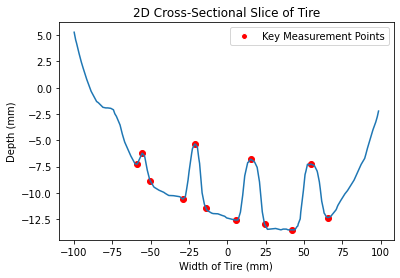

There are  4  tread valleys.

Tread valley # 1 :  1.85  mm
Tread valley # 2 :  5.67  mm
Tread valley # 3 :  5.98  mm
Tread valley # 4 :  5.68  mm


Seriously consider replacing your tires as soon as possible. 
For winter use, your tires are legally bald and need to be replaced.



In [6]:
# Main Function

filename = askopenfilename()                   # Prompts user to select STL mesh file
mesh = trimesh.load(filename)                  # Loads the STL mesh file

slice = mesh.section(plane_origin=mesh.centroid, plane_normal=[0,0,1])    # Gets a 3D slice from the mesh
slice_2D, to_3D = slice.to_planar()                                       # Converts to 2D slice

vertices = slice_2D.vertices                   # Extracts the vertices/points from the slice
vertices = vertices[vertices[:,0].argsort()]   # Sorts them in ascending x-direction (otherwise completely random order by default)
vertices = filter_slice(vertices)              # Gets rid of outliers
vertices = np.asarray(vertices)                # Converts to numpy array for easy visulization/manipulation

#lowess = sm.nonparametric.lowess
#vertices = lowess(vertices[:,1], vertices[:,0], 0)
#np.set_printoptions(suppress=True)             # Removes scientific notation (otherwise scientific notation by default)

upper_l, upper_r, lower, tread_depths = calculate_tread_depth(vertices)   # Calculates and returns the tread depth values

plt.figure()                                   # Plot the slice/vertices, including the overlaying key measurement vertices
plt.plot(vertices[:,0], vertices[:,1])
plt.scatter(upper_l[:,0], upper_l[:,1], facecolor='r')
plt.scatter(upper_r[:,0], upper_r[:,1], facecolor='r')
plt.scatter(lower[:,0], lower[:,1], facecolor = 'r')
label = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red", label='Key Measurement Points')
plt.legend(handles=[label])
plt.xlabel('Width of Tire (mm)')
plt.ylabel('Depth (mm)')
plt.title('2D Cross-Sectional Slice of Tire')
plt.show()

display_tread_depth(tread_depths)               # Display the tread depth information